In [1]:
import pandas as pd
from collections import Counter

In [2]:
df = pd.read_csv("/content/corpus_dir-max_num_gloss=5-augmented.csv")
df.head(10)

,id,sentence,sense_keys,glosses,targets
0,d000.s000.t000,How [TGT] long [TGT] has it been since you rev...,"['long%5:00:00:abundant:00', 'long%3:00:01::',...",['having or being more than normal or necessar...,[2]
1,d000.s000.t001,How long has it [TGT] been [TGT] since you rev...,"['be%2:42:04::', 'be%2:42:01::', 'be%2:42:08::...","['happen, occur, take place', 'have life, be a...",[4]
2,d000.s000.t002,How long has it been since you [TGT] reviewed ...,"['review%2:31:01::', 'review%2:31:02::', 'revi...","['look back upon (a period of time, sequence o...",[3]
3,d000.s000.t003,How long has it been since you reviewed the [T...,"['objective%1:09:00::', 'objective%1:06:00::']",['the goal intended to be attained (and which ...,[0]
4,d000.s000.t004,How long has it been since you reviewed the ob...,"['benefit%1:07:00::', 'benefit%1:10:00::', 'be...","['something that aids or promotes well-being',...",[2]
5,d000.s000.t005,How long has it been since you reviewed the ob...,"['service%1:04:04::', 'service%1:04:07::', 'se...",['the act of delivering a writ or summons upon...,[1]
6,d000.s000.t006,How long has it been since you reviewed the ob...,"['program%1:04:00::', 'program%1:10:02::', 'pr...",['a performance (or series of performances) at...,[3]
7,d000.s001.t000,Have you [TGT] permitted [TGT] it to become a ...,"['permit%2:41:00::', 'permit%2:32:06::', 'perm...",['make it possible through a specific action o...,[0]
8,d000.s001.t001,Have you permitted it to [TGT] become [TGT] a ...,"['become%2:42:03::', 'become%2:30:00::', 'beco...","['enhance the appearance of', 'enter or assume...",[3]
9,d000.s001.t002,Have you permitted it to become a [TGT] giveaw...,"['giveaway%1:10:00::', 'giveaway%1:21:00::', '...","['an unintentional disclosure', 'a gift of pub...",[1]


In [3]:
# Supposons que 'df' est votre dataframe
df_filtered = df[df['sense_keys'].apply(lambda x: len(eval(x)) >= 3)]

# Nombre total de lignes avant le filtrage
total_rows = len(df)

# Nombre de lignes après le filtrage
filtered_rows = len(df_filtered)

# Pourcentage de lignes conservées
percentage_kept = (filtered_rows / total_rows) * 100

print(f"Nombre total de lignes : {total_rows}")
print(f"Nombre de lignes conservées : {filtered_rows}")
print(f"Pourcentage de lignes conservées : {percentage_kept:.2f}%")

Nombre total de lignes : 263632
Nombre de lignes conservées : 179413
Pourcentage de lignes conservées : 68.05%


In [4]:
# Vérifiez les 5 premières lignes
print(df_filtered["glosses"].head())

# Vérifiez les valeurs nulles ou incorrectes
print(df_filtered["glosses"].isnull().sum())  # Nombre de glosses nulles
print(df_filtered["glosses"].apply(lambda x: isinstance(x, list)).value_counts())  # Vérifiez si ce sont bien des listes

0    ['having or being more than normal or necessar...
1    ['happen, occur, take place', 'have life, be a...
2    ['look back upon (a period of time, sequence o...
4    ['something that aids or promotes well-being',...
5    ['the act of delivering a writ or summons upon...
Name: glosses, dtype: object
0
glosses
False    179413
Name: count, dtype: int64


In [5]:
print(len(df))
print(len(df_filtered))

263632
179413


In [6]:
df = df_filtered

In [7]:
print(len(df))
print(len(df_filtered))

179413
179413


In [8]:
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

def extract_target_word(sentence):
    """Extrait le mot cible entre les balises [TGT]"""
    pattern = r'\[TGT\](.*?)\[TGT\]'
    matches = re.findall(pattern, sentence)
    return matches[0].strip() if matches else None

def parse_targets(targets_str):
    """Parse la chaîne de caractères des cibles en liste d'entiers"""
    cleaned = targets_str.strip('[]')
    return [int(x.strip()) for x in cleaned.split(',')]

def analyze_sense_distribution(df):
    """Analyse la distribution des sens pour chaque mot cible"""
    word_sense_distribution = defaultdict(lambda: defaultdict(int))

    # Calculer la distribution
    for index, row in df.iterrows():
        word = row['target_word']
        sense_indices = parse_targets(row['targets'])
        for sense_index in sense_indices:
            word_sense_distribution[word][sense_index] += 1

    # Calculer des statistiques
    word_stats = {}
    for word in word_sense_distribution:
        distribution = word_sense_distribution[word]
        total_occurrences = sum(distribution.values())
        n_senses = len(distribution)
        most_common_sense = max(distribution.items(), key=lambda x: x[1])

        word_stats[word] = {
            'total_occurrences': total_occurrences,
            'number_of_senses': n_senses,
            'most_common_sense': most_common_sense[0],
            'most_common_sense_count': most_common_sense[1],
            'distribution': dict(distribution)
        }

    return word_stats

def plot_sense_distribution(word_stats, top_n=10):
    """Visualise la distribution des sens pour les top_n mots les plus fréquents"""
    # Trier les mots par nombre total d'occurrences
    sorted_words = sorted(word_stats.items(),
                        key=lambda x: x[1]['total_occurrences'],
                        reverse=True)[:top_n]

    fig, ax = plt.subplots(figsize=(12, 6))

    x_pos = 0
    tick_positions = []
    tick_labels = []

    for word, stats in sorted_words:
        distribution = stats['distribution']
        positions = [x_pos + i for i in range(len(distribution))]
        tick_positions.extend(positions)
        tick_labels.extend([f"{word}_{i}" for i in distribution.keys()])

        plt.bar(positions, distribution.values())
        x_pos += len(distribution) + 1

    plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')
    plt.ylabel('Nombre d\'occurrences')
    plt.title('Distribution des sens par mot')
    plt.tight_layout()

    return plt

# Utilisation
def main(df):
    # Ajouter la colonne des mots cibles
    df['target_word'] = df['sentence'].apply(extract_target_word)

    # Analyser la distribution
    word_stats = analyze_sense_distribution(df)

    # Afficher les statistiques pour les 5 premiers mots
    for word in list(word_stats.keys())[:5]:
        print(f"\nMot: {word}")
        print(f"Nombre total d'occurrences: {word_stats[word]['total_occurrences']}")
        print(f"Nombre de sens différents: {word_stats[word]['number_of_senses']}")
        print(f"Sens le plus commun: {word_stats[word]['most_common_sense']} "
              f"({word_stats[word]['most_common_sense_count']} occurrences)")
        print("Distribution complète:", word_stats[word]['distribution'])

    # Créer la visualisation
    plot_sense_distribution(word_stats)

    return word_stats


Mot: long
Nombre total d'occurrences: 187
Nombre de sens différents: 5
Sens le plus commun: 4 (53 occurrences)
Distribution complète: {2: 27, 1: 32, 4: 53, 3: 40, 0: 35}

Mot: been
Nombre total d'occurrences: 622
Nombre de sens différents: 5
Sens le plus commun: 1 (149 occurrences)
Distribution complète: {4: 126, 3: 120, 1: 149, 0: 109, 2: 118}

Mot: reviewed
Nombre total d'occurrences: 12
Nombre de sens différents: 5
Sens le plus commun: 2 (5 occurrences)
Distribution complète: {3: 1, 1: 2, 2: 5, 4: 1, 0: 3}

Mot: benefit
Nombre total d'occurrences: 14
Nombre de sens différents: 3
Sens le plus commun: 2 (6 occurrences)
Distribution complète: {2: 6, 0: 5, 1: 3}

Mot: service
Nombre total d'occurrences: 41
Nombre de sens différents: 5
Sens le plus commun: 0 (13 occurrences)
Distribution complète: {1: 9, 2: 9, 3: 7, 0: 13, 4: 3}


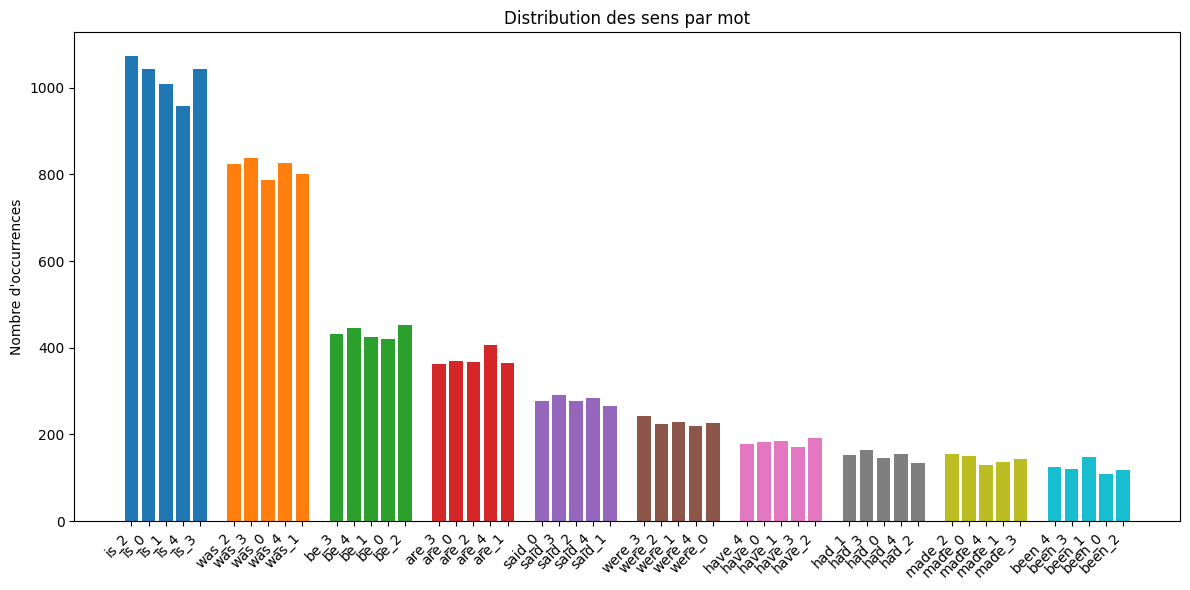

In [9]:
word_stats = main(df)

In [10]:
def analyze_word_occurrences(df, word=None, occurrence_count=None, show_extremes=False):
    """
    Analyse les occurrences des mots dans le dataset avec différentes options

    Args:
        df: DataFrame source
        word: Mot spécifique à analyser (optionnel)
        occurrence_count: Nombre d'occurrences à rechercher (optionnel)
        show_extremes: Afficher les sens les plus/moins fréquents pour chaque mot
    """
    def get_word_sense_distribution(word_data):
        sense_count = defaultdict(int)
        for targets in word_data['targets']:
            for sense in eval(targets):
                sense_count[sense] += 1
        return dict(sense_count)

    def print_word_details(word_data, distribution):
        print(f"\nAnalyse pour le mot '{word_data['target_word'].iloc[0]}':")
        print(f"Nombre total d'occurrences: {len(word_data)}")

        # Afficher toutes les occurrences avec leurs détails
        print("\nDétails de chaque occurrence:")
        for idx, row in word_data.iterrows():
            print("\n-------------------")
            for column in df.columns:
                print(f"{column}: {row[column]}")

        if show_extremes:
            # Trouver et afficher le sens le plus/moins commun
            most_common = max(distribution.items(), key=lambda x: x[1])
            least_common = min(distribution.items(), key=lambda x: x[1])
            print(f"\nSens le plus commun: {most_common[0]} ({most_common[1]} occurrences)")
            print(f"Sens le moins commun: {least_common[0]} ({least_common[1]} occurrences)")

    # Cas 1: Analyser un mot spécifique
    if word is not None:
        word_data = df[df['target_word'] == word]
        if len(word_data) == 0:
            print(f"Aucune occurrence trouvée pour le mot '{word}'")
            return

        distribution = get_word_sense_distribution(word_data)
        print_word_details(word_data, distribution)

    # Cas 2: Rechercher les mots avec un certain nombre d'occurrences
    elif occurrence_count is not None:
        found_words = []
        for word in df['target_word'].unique():
            word_data = df[df['target_word'] == word]
            distribution = get_word_sense_distribution(word_data)

            # Vérifier si un des sens a exactement le nombre d'occurrences demandé
            if occurrence_count in distribution.values():
                found_words.append(word)
                print(f"\nMot trouvé: '{word}' avec {occurrence_count} occurrences pour au moins un sens")
                print_word_details(word_data, distribution)

        if not found_words:
            print(f"Aucun mot trouvé avec exactement {occurrence_count} occurrences pour un de ses sens")

    # Cas 3: Analyser tous les mots
    else:
        for word in df['target_word'].unique():
            word_data = df[df['target_word'] == word]
            distribution = get_word_sense_distribution(word_data)
            print_word_details(word_data, distribution)

In [ ]:
# Exemples d'utilisation:
"""
# Pour voir toutes les occurrences d'un mot spécifique avec ses sens extrêmes:
analyze_word_occurrences(df, word="reviewed", show_extremes=True)

# Pour trouver tous les mots qui ont un sens avec exactement 34 occurrences:
analyze_word_occurrences(df, occurrence_count=34)

# Pour voir tous les mots avec leurs sens extrêmes:
analyze_word_occurrences(df, show_extremes=True)
"""

In [11]:
# Pour voir toutes les occurrences d'un mot spécifique avec ses sens extrêmes:
analyze_word_occurrences(df, word="reviewed", show_extremes=True)


Analyse pour le mot 'reviewed':
Nombre total d'occurrences: 12

Détails de chaque occurrence:

-------------------
id: d000.s000.t002
sentence: How long has it been since you [TGT] reviewed [TGT] the objectives of your benefit and service program ?
sense_keys: ['review%2:31:01::', 'review%2:31:02::', 'review%2:32:00::', 'review%2:31:00::', 'review%2:31:04::']
glosses: ['look back upon (a period of time, sequence of events); remember', 'hold a review (of troops)', 'appraise critically', 'look at again; examine again', "refresh one's memory"]
targets: [3]
target_word: reviewed

-------------------
id: d036.s098.t002
sentence: Are annual marketing plans [TGT] reviewed [TGT] throughout your management group to get the perspective of all individuals and get everyone on the marketing team ?
sense_keys: ['review%2:31:01::', 'review%2:31:00::', 'review%2:31:02::', 'review%2:31:04::', 'review%2:32:00::']
glosses: ['look back upon (a period of time, sequence of events); remember', 'look at agai

In [31]:
from collections import defaultdict

def create_sense_mapping(df, word):
    """
    Crée une correspondance complète entre les sense_keys et leurs définitions
    en prenant en compte toutes les occurrences du mot
    """
    sense_mapping = {}

    # Parcourir toutes les lignes pour le mot donné
    word_data = df[df['target_word'] == word]
    for _, row in word_data.iterrows():
        sense_keys = eval(row['sense_keys'])
        glosses = eval(row['glosses'])

        # Ajouter chaque paire sense_key/gloss au dictionnaire
        for key, gloss in zip(sense_keys, glosses):
            if key not in sense_mapping:
                sense_mapping[key] = gloss

    return sense_mapping

from collections import defaultdict

def analyze_word_senses_improved(df, word):
    """
    Analyse les sens d'un mot en maintenant une correspondance cohérente.

    Args:
        df: DataFrame contenant les données d'analyse.
        word: Mot cible pour l'analyse.
    """
    # Filtrer les données pour le mot spécifique
    word_data = df[df['target_word'] == word]
    if word_data.empty:
        print(f"Aucune donnée trouvée pour le mot '{word}'.")
        return

    # Créer la correspondance fixe sense_key -> définition
    sense_mapping = create_sense_mapping(df, word)
    if not sense_mapping:
        print(f"Aucune correspondance de sens trouvée pour le mot '{word}'.")
        return

    # Dictionnaire pour compter les occurrences de chaque sense_key
    sense_counts = defaultdict(int)

    print(f"\nAnalyse détaillée pour le mot '{word}':")
    print("\nCorrespondance sense_key -> définition:")
    for key, gloss in sense_mapping.items():
        print(f"{key}: {gloss}")

    print("\nAnalyse des occurrences:")
    for idx, row in word_data.iterrows():
        try:
            # Récupérer le target et les sense keys
            targets = eval(row['targets'])
            sense_keys = eval(row['sense_keys'])

            # Vérification des indices
            if not targets or not sense_keys:
                print(f"Données invalides pour l'index {idx}.")
                continue

            target = targets[0]  # L'index utilisé
            target_sense_key = sense_keys[target]  # Le sense_key effectivement utilisé

            print(f"\n{'='*50}")
            print(f"Phrase: {row['sentence']}")
            print(f"Target utilisé: {target}")
            print(f"Sense key: {target_sense_key}")
            print(f"Définition: {sense_mapping[target_sense_key]}")

            # Incrémenter le compte pour le sense_key
            sense_counts[target_sense_key] += 1
        except (IndexError, KeyError, SyntaxError) as e:
            print(f"Erreur lors du traitement de l'index {idx}: {e}")
            continue

    # Résumé des occurrences par sens
    if not sense_counts:
        print(f"Aucun sense key trouvé pour le mot '{word}'.")
        return

    print("\nRésumé des occurrences par sens:")
    for sense_key, count in sorted(sense_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"\nSense key: {sense_key}")
        print(f"Définition: {sense_mapping[sense_key]}")
        print(f"Nombre d'occurrences: {count}")

    # Identifier les sens les plus et moins communs
    most_common = max(sense_counts.items(), key=lambda x: x[1])
    least_common = min(sense_counts.items(), key=lambda x: x[1])

    print("\nStatistiques finales:")
    print(f"Sens le plus commun: '{sense_mapping[most_common[0]]}' ({most_common[1]} occurrences)")
    print(f"Sens le moins commun: '{sense_mapping[least_common[0]]}' ({least_common[1]} occurrences)")

# Fonction pour chercher des occurrences spécifiques
def find_specific_occurrences(df, occurrence_count):
    """
    Trouve tous les mots qui ont un sens avec exactement le nombre d'occurrences spécifié
    """
    results = {}

    for word in df['target_word'].unique():
        word_data = df[df['target_word'] == word]
        sense_counts = defaultdict(int)

        for row in word_data.iterrows():
            target = eval(row[1]['targets'])[0]
            sense_counts[target] += 1

        # Vérifier si un des sens a le nombre d'occurrences recherché
        for sense, count in sense_counts.items():
            if count == occurrence_count:
                if word not in results:
                    results[word] = []
                results[word].append((sense, count))

    return results

In [32]:
# Pour analyser un mot spécifique
analyze_word_senses_improved(df, "been")


Analyse détaillée pour le mot 'been':

Correspondance sense_key -> définition:
be%2:42:04::: happen, occur, take place
be%2:42:01::: have life, be alive
be%2:42:08::: represent, as of a character on stage
be%2:42:07::: be identical or equivalent to
be%2:42:03::: have the quality of being; (copula, used with an adjective or a predicate noun)
be%2:42:09::: be priced at
be%2:42:06::: be identical to; be someone or something
be%2:42:00::: have an existence, be extant
be%2:42:05::: occupy a certain position or area; be somewhere
be%2:42:13::: to remain unmolested, undisturbed, or uninterrupted -- used only in infinitive form
be%2:41:00::: work in a specific place, with a specific subject, or in a specific function
be%2:40:00::: spend or use time
be%2:42:02::: form or compose

Analyse des occurrences:

Phrase: How long has it [TGT] been [TGT] since you reviewed the objectives of your benefit and service program ?
Target utilisé: 4
Sense key: be%2:42:03::
Définition: have the quality of bein

In [33]:
# Pour analyser un mot spécifique
analyze_word_senses_improved(df, "reviewed")


Analyse détaillée pour le mot 'reviewed':

Correspondance sense_key -> définition:
review%2:31:01::: look back upon (a period of time, sequence of events); remember
review%2:31:02::: hold a review (of troops)
review%2:32:00::: appraise critically
review%2:31:00::: look at again; examine again
review%2:31:04::: refresh one's memory

Analyse des occurrences:

Phrase: How long has it been since you [TGT] reviewed [TGT] the objectives of your benefit and service program ?
Target utilisé: 3
Sense key: review%2:31:00::
Définition: look at again; examine again

Phrase: Are annual marketing plans [TGT] reviewed [TGT] throughout your management group to get the perspective of all individuals and get everyone on the marketing team ?
Target utilisé: 1
Sense key: review%2:31:00::
Définition: look at again; examine again

Phrase: All comments concerning effectiveness and use of drugs have been carefully [TGT] reviewed [TGT] by a veterinary medical officer with FDA .
Target utilisé: 2
Sense key: re

In [18]:
# Pour trouver les mots avec un certain nombre d'occurrences
results = find_specific_occurrences(df, 34)
for word, senses in results.items():
    print(f"\nMot '{word}' a des sens avec {34} occurrences:")


Mot 'rather' a des sens avec 34 occurrences:

Mot 'done' a des sens avec 34 occurrences:

Mot 'number' a des sens avec 34 occurrences:

Mot 'play' a des sens avec 34 occurrences:

Mot 'important' a des sens avec 34 occurrences:

Mot 'interest' a des sens avec 34 occurrences:

Mot 'hope' a des sens avec 34 occurrences:

Mot 'big' a des sens avec 34 occurrences:

Mot 'says' a des sens avec 34 occurrences:

Mot 'looked' a des sens avec 34 occurrences:

Mot 'next' a des sens avec 34 occurrences:

Mot 'took' a des sens avec 34 occurrences:

Mot 'room' a des sens avec 34 occurrences:

Mot 'gave' a des sens avec 34 occurrences:

Mot 'large' a des sens avec 34 occurrences:

Mot 'however' a des sens avec 34 occurrences:

Mot 'small' a des sens avec 34 occurrences:

Mot 'got' a des sens avec 34 occurrences:


# Equilibré la distribution des sens

In [23]:
def normalize_sense_distribution(df, max_occurrences=3):
    """
    Normalise la distribution des sens en limitant le nombre maximum d'occurrences
    et en appliquant de l'oversampling pour les sens sous-représentés.

    Args:
        df: DataFrame contenant les données
        max_occurrences: Nombre maximum d'occurrences souhaité par sens

    Returns:
        DataFrame normalisé
    """
    normalized_data = []

    # Traiter chaque mot unique dans le dataset
    for word in df['target_word'].unique():
        word_data = df[df['target_word'] == word]
        sense_counts = defaultdict(list)

        # Grouper les lignes par sense_key
        for idx, row in word_data.iterrows():
            target = eval(row['targets'])[0]
            sense_keys = eval(row['sense_keys'])
            target_sense_key = sense_keys[target]
            sense_counts[target_sense_key].append(row.to_dict())

        # Normaliser chaque sens
        for sense_key, rows in sense_counts.items():
            if len(rows) > max_occurrences:
                # Sous-échantillonnage : prendre les premiers max_occurrences exemples
                normalized_data.extend(rows[:max_occurrences])
            elif len(rows) < max_occurrences:
                # Oversampling : dupliquer les exemples existants
                while len(rows) < max_occurrences:
                    rows.append(rows[0])  # Dupliquer le premier exemple
                normalized_data.extend(rows)
            else:
                # Cas où le nombre d'occurrences est déjà égal à max_occurrences
                normalized_data.extend(rows)

    # Créer un nouveau DataFrame avec les données normalisées
    normalized_df = pd.DataFrame(normalized_data)

    # Réinitialiser l'index
    normalized_df = normalized_df.reset_index(drop=True)

    return normalized_df

def analyze_balance_results(original_df, normalized_df, start_idx=None, end_idx=None, target_word=None):
    """
    Analyse et affiche les résultats de l'équilibrage pour une plage d'indices spécifique
    ou pour un mot ciblé.

    Args:
        original_df: DataFrame original
        normalized_df: DataFrame normalisé
        start_idx: Index de début pour l'analyse (optionnel)
        end_idx: Index de fin pour l'analyse (optionnel)
        target_word: Mot spécifique à analyser (optionnel)
    """
    if target_word:
        # Analyse pour un mot spécifique
        orig_word_data = original_df[original_df['target_word'] == target_word]
        norm_word_data = normalized_df[normalized_df['target_word'] == target_word]

        print(f"\nAnalyse pour le mot '{target_word}':")
        print(f"Nombre d'occurrences original : {len(orig_word_data)}")
        print(f"Nombre d'occurrences après normalisation : {len(norm_word_data)}")

        print("\nDistribution originale :")
        analyze_word_senses_improved(original_df, target_word)
        print("\nDistribution après normalisation :")
        analyze_word_senses_improved(normalized_df, target_word)

    elif start_idx is not None and end_idx is not None:
        # Analyse pour une plage d'indices
        orig_slice = original_df.iloc[start_idx:end_idx]
        norm_slice = normalized_df.iloc[start_idx:end_idx]

        print(f"\nAnalyse pour les indices {start_idx} à {end_idx}:")
        print(f"Nombre de lignes original : {len(orig_slice)}")
        print(f"Nombre de lignes après normalisation : {len(norm_slice)}")

        # Analyser les mots uniques dans cette plage
        unique_words = orig_slice['target_word'].unique()
        for word in unique_words:
            print(f"\n{'='*50}")
            print(f"Mot : {word}")
            print("Distribution originale :")
            analyze_word_senses_improved(orig_slice, word)
            print("\nDistribution après normalisation :")
            analyze_word_senses_improved(norm_slice, word)

    else:
        print("Veuillez spécifier soit un mot cible, soit une plage d'indices à analyser.")

In [24]:
# Créer le dataset normalisé
normalized_df = normalize_sense_distribution(df, max_occurrences=3)

In [28]:
analyze_balance_results(df, normalized_df, target_word="been")


Analyse pour le mot 'been':
Nombre d'occurrences original : 621
Nombre d'occurrences après normalisation : 30

Distribution originale :

Analyse détaillée pour le mot 'been':

Correspondance sense_key -> définition:
be%2:42:04::: happen, occur, take place
be%2:42:01::: have life, be alive
be%2:42:08::: represent, as of a character on stage
be%2:42:07::: be identical or equivalent to
be%2:42:03::: have the quality of being; (copula, used with an adjective or a predicate noun)
be%2:42:09::: be priced at
be%2:42:06::: be identical to; be someone or something
be%2:42:00::: have an existence, be extant
be%2:42:05::: occupy a certain position or area; be somewhere
be%2:42:13::: to remain unmolested, undisturbed, or uninterrupted -- used only in infinitive form
be%2:41:00::: work in a specific place, with a specific subject, or in a specific function
be%2:40:00::: spend or use time
be%2:42:02::: form or compose

Analyse des occurrences:

Phrase: How long has it [TGT] been [TGT] since you rev

In [35]:
analyze_balance_results(df, normalized_df, start_idx=100, end_idx=300)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.

Analyse des occurrences:

Phrase: Are you carefully policing wash-up time and [TGT] rest [TGT] periods to be certain that all other time is productive ?
Target utilisé: 3
Sense key: rest%1:04:00::
Définition: freedom from activity (work or strain or responsibility)

Résumé des occurrences par sens:

Sense key: rest%1:04:00::
Définition: freedom from activity (work or strain or responsibility)
Nombre d'occurrences: 1

Statistiques finales:
Sens le plus commun: 'freedom from activity (work or strain or responsibility)' (1 occurrences)
Sens le moins commun: 'freedom from activity (work or strain or responsibility)' (1 occurrences)

Distribution après normalisation :
Aucune donnée trouvée pour le mot 'rest'.

Mot : periods
Distribution originale :

Analyse détaillée pour le mot 'periods':

Correspondance sense_key -> définition:
period%1:28:02::: the interval taken to complete one cycle of a regularly repeating 

In [36]:
def analyze_balance_results_graph(original_df, normalized_df, start_idx=None, end_idx=None, target_word=None):
    """
    Visualise la comparaison des distributions avant et après normalisation.

    Args:
        original_df: DataFrame original
        normalized_df: DataFrame normalisé
        start_idx: Index de début pour l'analyse (optionnel)
        end_idx: Index de fin pour l'analyse (optionnel)
        target_word: Mot spécifique à analyser (optionnel)
    """
    def get_sense_distribution(df, word):
        word_data = df[df['target_word'] == word]
        sense_counts = defaultdict(int)

        for _, row in word_data.iterrows():
            target = eval(row['targets'])[0]
            sense_keys = eval(row['sense_keys'])
            target_sense_key = sense_keys[target]
            sense_counts[target_sense_key] += 1

        return dict(sense_counts)

    def plot_distributions(words_to_analyze):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        fig.suptitle('Distribution des sens avant et après normalisation')

        # Configuration des sous-graphiques
        for ax, title in zip([ax1, ax2], ['Distribution originale', 'Distribution normalisée']):
            x_pos = 0
            tick_positions = []
            tick_labels = []

            for word in words_to_analyze:
                distribution = get_sense_distribution(
                    original_df if ax == ax1 else normalized_df,
                    word
                )

                positions = [x_pos + i for i in range(len(distribution))]
                values = list(distribution.values())

                ax.bar(positions, values, label=word)

                tick_positions.extend(positions)
                tick_labels.extend([f"{word}_{i}" for i in range(len(distribution))])

                x_pos += len(distribution) + 2

            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels, rotation=45, ha='right')
            ax.set_ylabel('Nombre d\'occurrences')
            ax.set_title(title)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Sélection des données à analyser
    if target_word:
        words_to_analyze = [target_word]
    elif start_idx is not None and end_idx is not None:
        slice_df = original_df.iloc[start_idx:end_idx]
        words_to_analyze = slice_df['target_word'].unique()
    else:
        print("Veuillez spécifier soit un mot cible, soit une plage d'indices à analyser.")
        return

    plot_distributions(words_to_analyze)

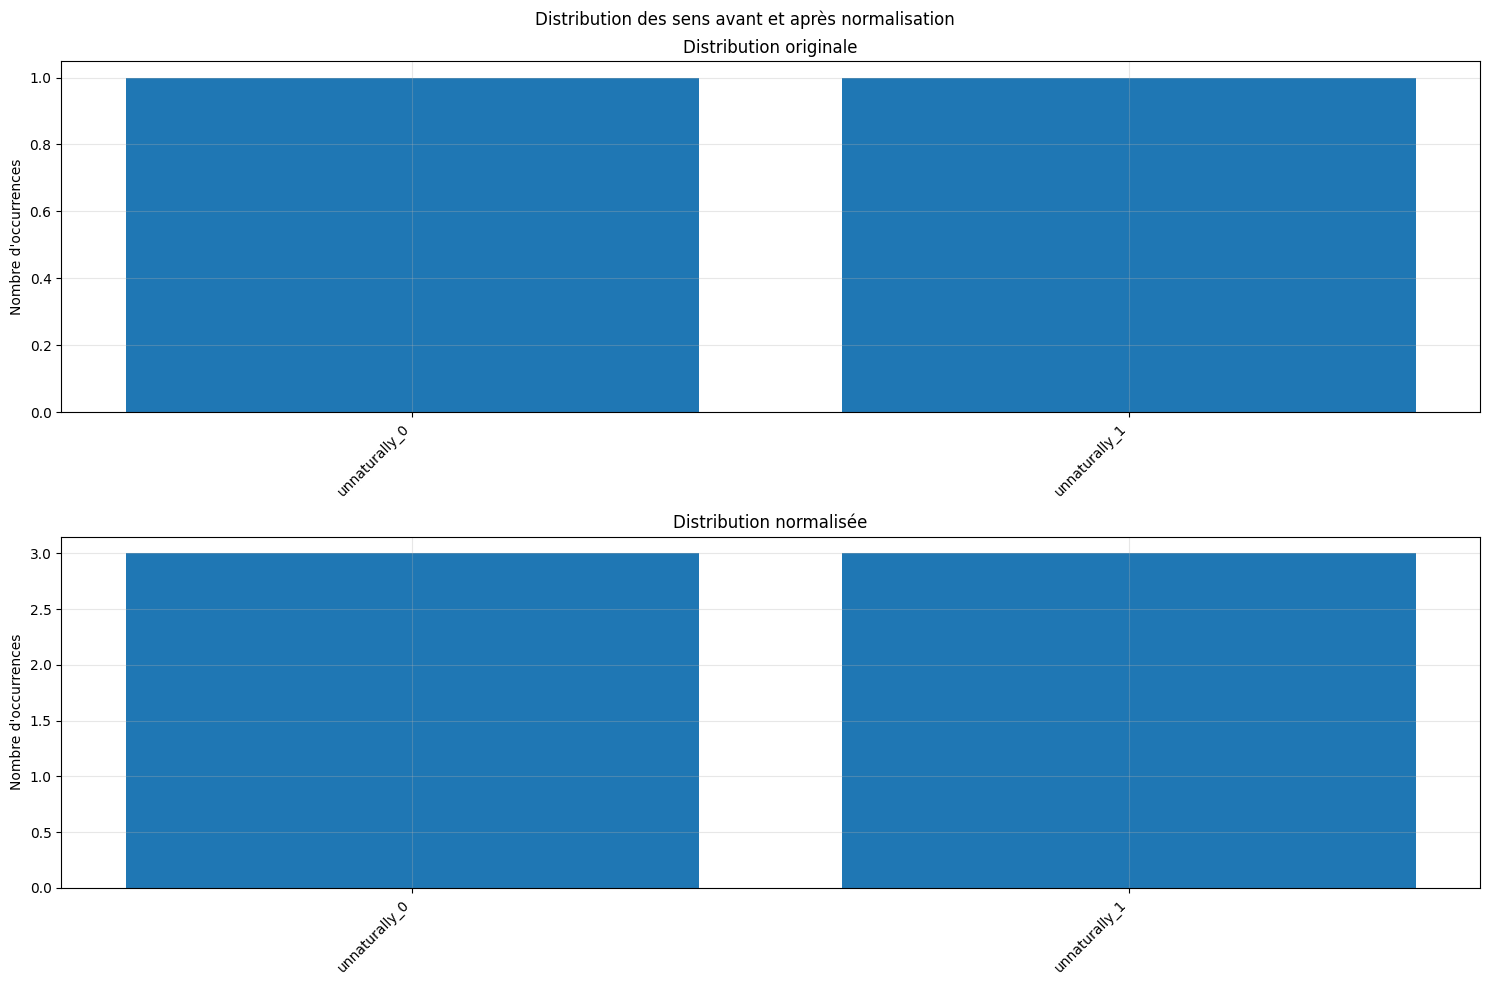

In [37]:
# Pour un mot spécifique
analyze_balance_results_graph(df, normalized_df, target_word="unnaturally")

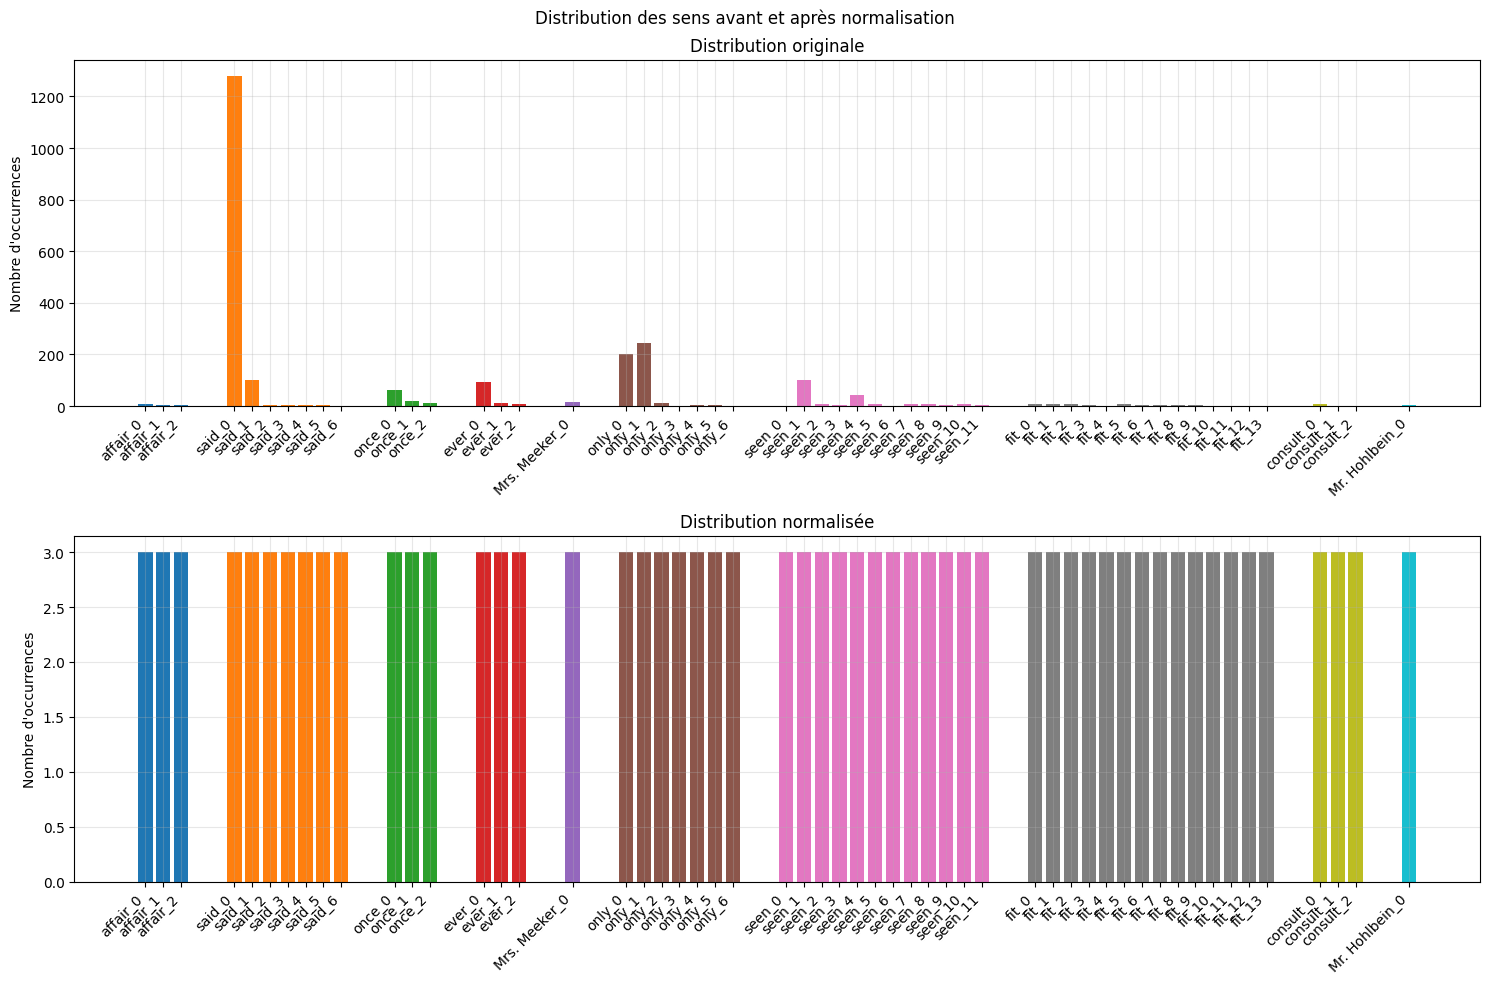

In [43]:
# Pour une plage d'indices
analyze_balance_results_graph(df, normalized_df, start_idx=1000, end_idx=1010)

# Verifications et sauvegarde du nouveau dataset

In [44]:
normalized_df.head()

,id,sentence,sense_keys,glosses,targets,target_word
0,d000.s000.t000,How [TGT] long [TGT] has it been since you rev...,"['long%5:00:00:abundant:00', 'long%3:00:01::',...",['having or being more than normal or necessar...,[2],long
1,d001.s081.t007,Two millions were added to what had been set a...,"['long%3:00:05::', 'long%3:00:00::', 'long%5:0...",['holding securities or commodities in expecta...,[4],long
2,d002.s039.t008,Hudson now proposed to sail all the way throug...,"['long%5:00:00:provident:00', 'long%3:00:01::'...","['planning prudently for the future', 'primari...",[3],long
3,d000.s100.t002,Vending machines can alleviate the [TGT] long ...,"['long%5:00:00:abundant:00', 'long%3:00:01::',...",['having or being more than normal or necessar...,[1],long
4,d002.s088.t004,All through July the Discovery picked her way ...,"['long%5:00:00:provident:00', 'long%3:00:02::'...","['planning prudently for the future', 'primari...",[4],long


In [45]:
len(normalized_df)

117339

In [46]:
# Sauvegarder le DataFrame en CSV
normalized_df.to_csv('normalized_dataset.csv', index=False, encoding='utf-8')